In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from modules import Kraken
from modules import TrendLine

In [2]:
import datetime
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt 

In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
constructor = Kraken(pair = 'DASH/EUR', 
                     api_key_file = 'kraken.key',
                     minimum_fund = 500, 
                     percent_alloc = 0.5)

In [5]:
df_daily = constructor.ohlcv(60*24,1000)
df_ssl = constructor.ohlcv(60,1000)

bull,bear = constructor.tr_zones(df_daily, 4)
bull_h,bear_h = constructor.tr_zones(df_ssl, 3)

df_ssl = constructor.recognize_candlestick(df_ssl)

df_ssl = constructor.ssl(df_ssl, 30)
df_ssl = constructor.stochastic(df = df_ssl,
                                fastk_period = 20, 
                                slowk_period = 3, 
                                slowd_period = 3)

df_daily = constructor.ema(df_daily,144)

In [6]:
tr = TrendLine(df = df_ssl, errpct= 0.005, col = 'close')
tr_daily = TrendLine(df = df_daily, errpct= 0.005, col = 'close')

In [7]:
minimaIdxs, maximaIdxs = tr.get_extrema(True), tr.get_extrema(False)
mintrend, maxtrend = tr.houghpt_trendln(minimaIdxs), tr.houghpt_trendln(maximaIdxs)
#mintrend, maxtrend = tr.naive_trendln(minimaIdxs), tr.naive_trendln(maximaIdxs)
#mintrend, maxtrend = tr.sorted_slope_trendln(minimaIdxs), tr.sorted_slope_trendln(maximaIdxs)
#mintrend, maxtrend = tr.hough_trendln(minimaIdxs), tr.hough_trendln(maximaIdxs)
df,m_mid,c_mid = tr.trendln(mintrend,maxtrend)

In [8]:
minimaIdxs_daily, maximaIdxs_daily = tr_daily.get_extrema(True), tr_daily.get_extrema(False)
mintrend_daily, maxtrend_daily = tr_daily.sorted_slope_trendln(minimaIdxs_daily), tr_daily.sorted_slope_trendln(maximaIdxs_daily)
df_daily,m_mid_daily,c_mid_daily = tr_daily.trendln(mintrend_daily,maxtrend_daily)

In [9]:
def rolling_regression(df,reg_range):

    multi_reg = []
    for i in range(0,len(df.index),10): 
        
        j= i +10
        
        if i == 0:
            x = np.array(range(len(df.close.index)))[-j:].reshape(-1,1)
            y = df.close.iloc[-j:].values.reshape(-1,1)
            
        else:
            x = np.array(range(len(df.close.index)))[-j:-i].reshape(-1,1)
            y = df.close.iloc[-j:-i].values.reshape(-1,1)
            

        reg = LinearRegression().fit(X = x, y = y)
        y_pred = reg.predict(x).flatten()
        multi_reg.append([y_pred,x,y,reg.coef_[0]])
        
    return multi_reg

In [10]:
multi_reg = rolling_regression(df_daily, 10)

## Visual

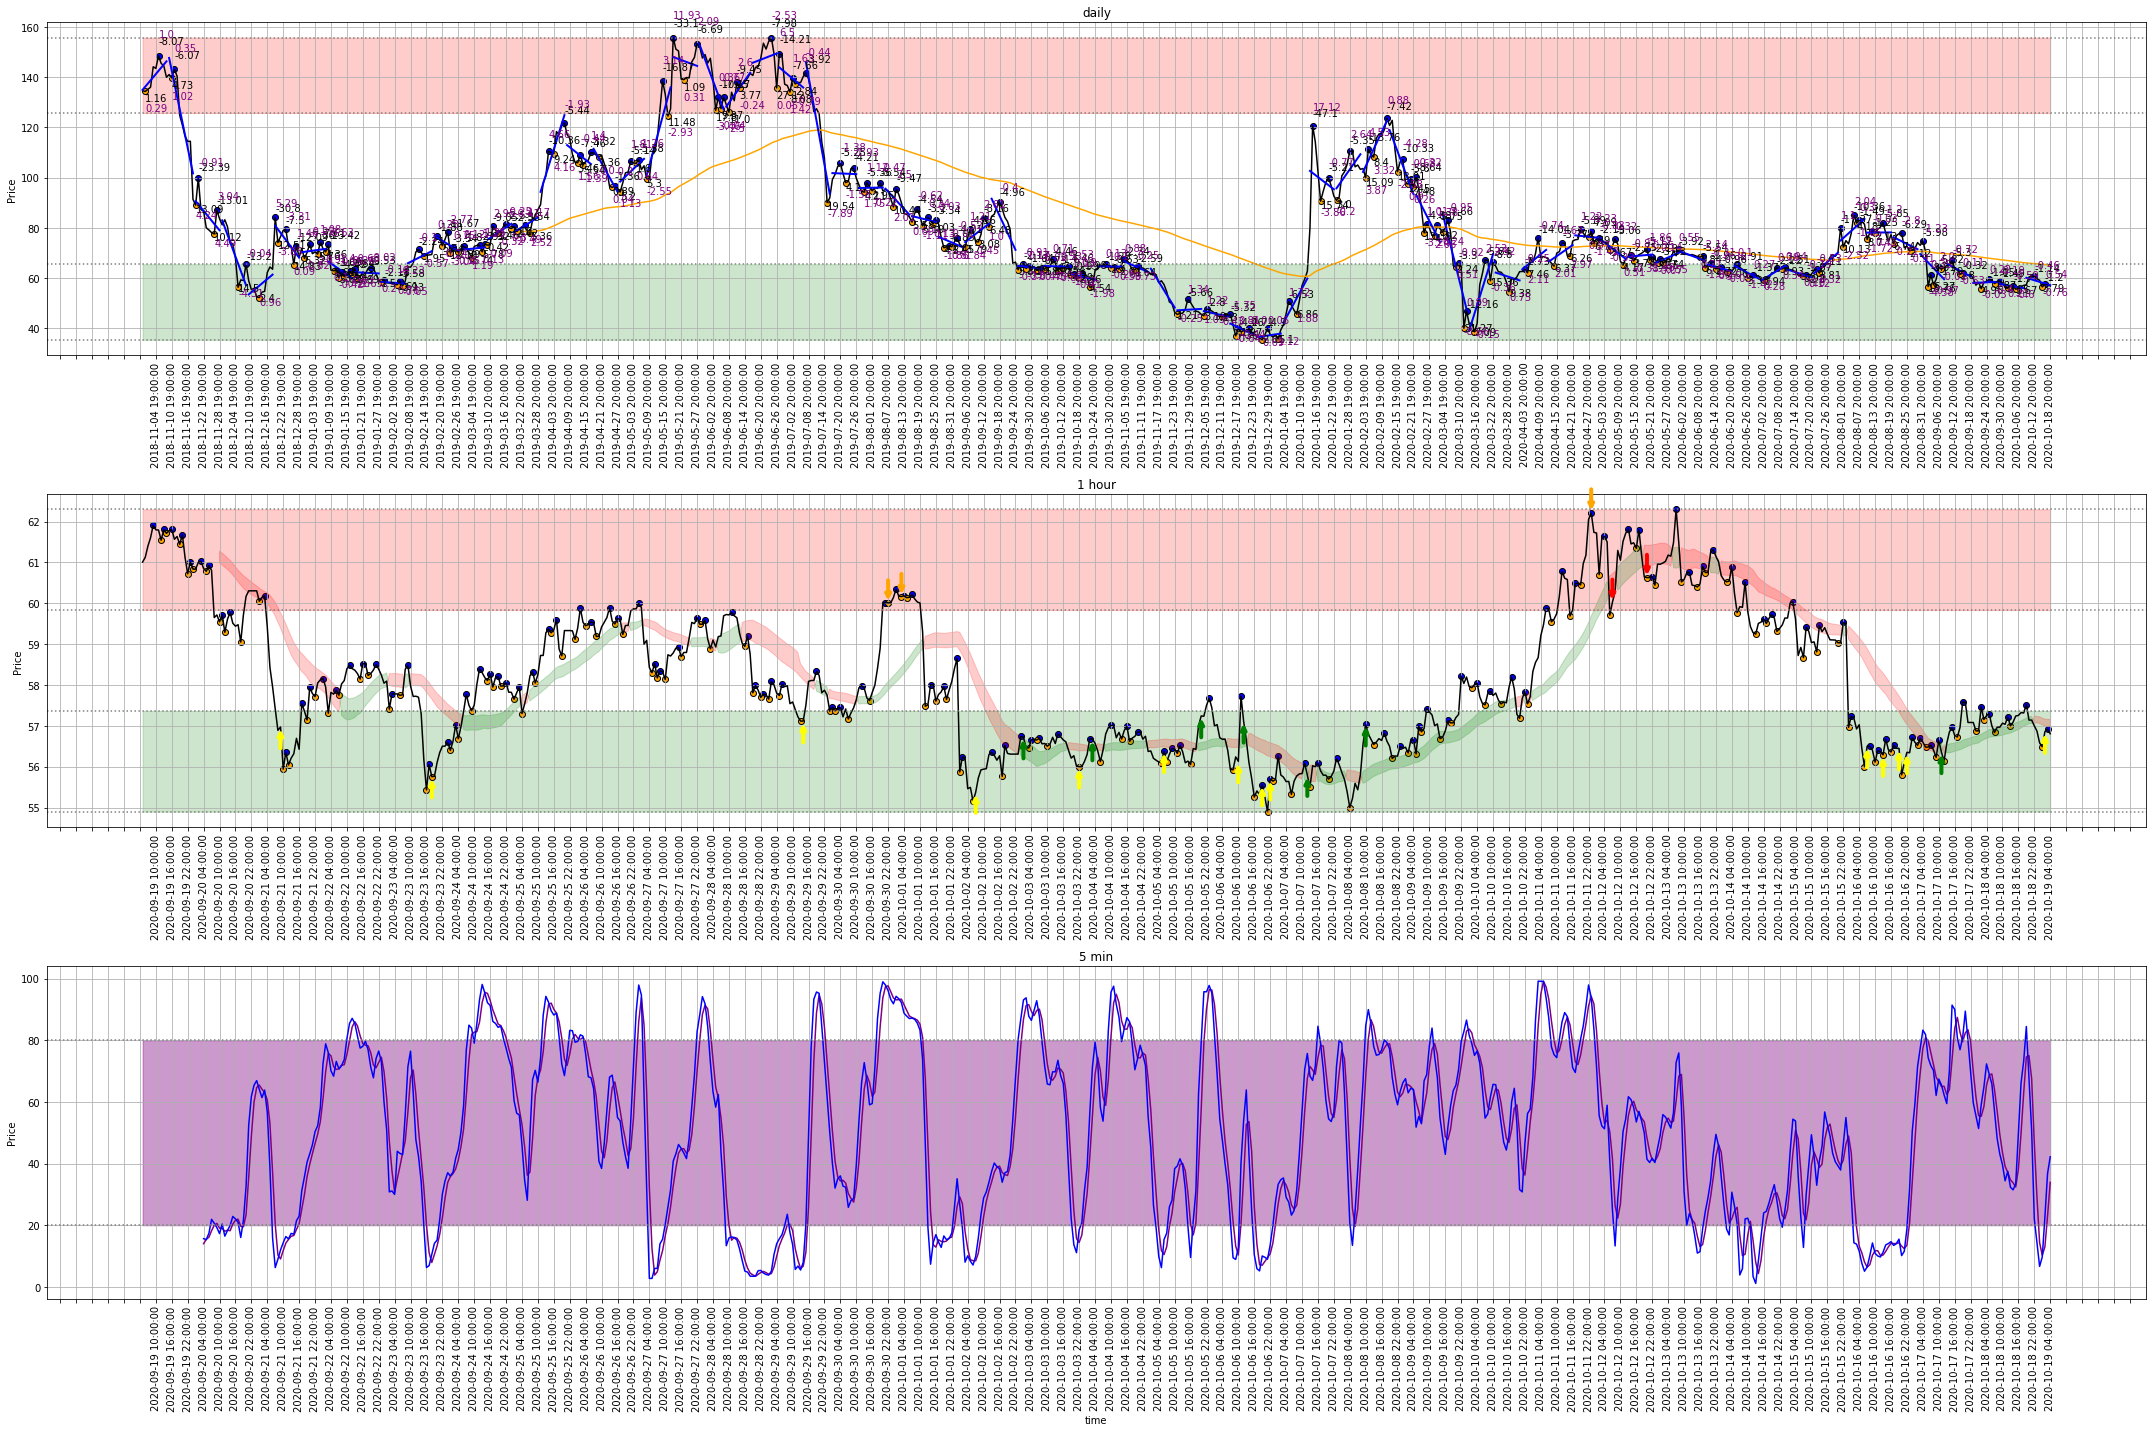

In [11]:
fig, ax = plt.subplots(3, 1,figsize=(30, 20))

ax[1].plot(df.close,
        color='k')

ax[0].plot(df_daily.close,
        color='k')
ax[0].plot(df_daily.ema,
        color='orange')

ax[2].plot(df_ssl.slowd,
        color='purple')

ax[2].plot(df_ssl.slowk,
        color='blue')

ax[0].axhline(y= max(df_daily.close),color='gray', ls = ':')
ax[0].axhline(y= min(df_daily.close),color='gray', ls = ':')
ax[0].axhline(y= bear, color='gray', ls = ':')
ax[0].axhline(y= bull, color='gray', ls = ':')


ax[0].fill_between(df_daily.index, max(df_daily.close), bear, color = 'red',
                   alpha=0.2, interpolate=True)
ax[0].fill_between(df_daily.index, min(df_daily.close), bull, color = 'green',
                   alpha=0.2, interpolate=True)


ax[1].axhline(y= max(df_ssl.close),color='gray', ls = ':')
ax[1].axhline(y= min(df_ssl.close),color='gray', ls = ':')
ax[1].axhline(y= bear_h, color='gray', ls = ':')
ax[1].axhline(y= bull_h, color='gray', ls = ':')


ax[1].fill_between(df_ssl.index, max(df_ssl.close), bear_h, color = 'red',
                   alpha=0.2, interpolate=True)
ax[1].fill_between(df_ssl.index, min(df_ssl.close), bull_h, color = 'green',
                   alpha=0.2, interpolate=True)



ax[0].scatter(df_daily.close.iloc[maximaIdxs_daily].index,
           df_daily.close.iloc[maximaIdxs_daily].values,color = 'blue',edgecolors = 'k')

ax[0].scatter(df_daily.close.iloc[minimaIdxs_daily].index,
           df_daily.close.iloc[minimaIdxs_daily].values,color = 'orange',edgecolors = 'k')


ax[1].scatter(df.close.iloc[maximaIdxs].index,
           df.close.iloc[maximaIdxs].values,color = 'blue',edgecolors = 'k')

ax[1].scatter(df.close.iloc[minimaIdxs].index,
           df.close.iloc[minimaIdxs].values,color = 'orange',edgecolors = 'k')

ax[2].axhline(y= 80, color='gray', ls = ':')
ax[2].axhline(y= 20, color='gray', ls = ':')


ax[2].fill_between(df_ssl.index, 80, 20, color = 'purple',
                   alpha=0.4, interpolate=True)

# ax[1].plot(df.support.index,
#            df.support.values, color = 'green', ls = ':')

# ax[1].plot(df.resistance.index,
#            df.resistance.values, color = 'red', ls = ':')

# ax[1].plot(df.mid.index,
#            df.mid.values, color = 'blue', ls = ':')

for i in multi_reg:

    ax[0].plot(np.array(df_daily.index[i[1]]).flatten(),
               i[0].flatten(), color = 'blue', lw = 2)

for i,t in enumerate(df.index):
    if ((df.green[i-1] > df.red[i-1]) and (df.green[i-2] < df.red[i-2]) and (df.green[i-3] < df.red[i-3]) and (df.green[i-4] < df.red[i-4]) and (df.green[i-5] < df.red[i-5]) and (df.green[i-6] < df.red[i-6])) and (df.close[i]<bull_h):
        ax[1].annotate('', xy=(t,df.close.loc[t]), xytext=(t,df.close.loc[t]*0.990),
                    arrowprops={'arrowstyle': '->', 'lw': 4, 'color': 'green'})
        
    elif ((df.green[i-1] < df.red[i-1]) and (df.green[i-2] > df.red[i-2]) and (df.green[i-3] > df.red[i-3]) and (df.green[i-4] > df.red[i-4]) and (df.green[i-5] > df.red[i-5]) and (df.green[i-6] > df.red[i-6])) and (df.close[i]>bear_h):
        ax[1].annotate('', xy=(t,df.close.loc[t]), xytext=(t,df.close.loc[t]*1.0100),
                    arrowprops={'arrowstyle': '->', 'lw': 4, 'color': 'red'})

for i,t in enumerate(df.index):
        
    bull = (((df.slowk[i-1]<20) and (df.slowd[i-1]<20)) and (df.slowk[i-1] < df.slowd[i-1]) and (df.slowk[i] > df.slowd[i]))
    bear = (((df.slowk[i-1]>80) and (df.slowd[i-1]>80)) and (df.slowk[i-1] > df.slowd[i-1]) and (df.slowk[i] < df.slowd[i]))
    
    if bull and (df.close[i]<bull_h):
        ax[1].annotate('', xy=(t,df.close.loc[t]), xytext=(t,df.close.loc[t]*0.990),
            arrowprops={'arrowstyle': '->', 'lw': 4, 'color': 'yellow'})
        
    elif bear and (df.close[i]>bear_h):
        ax[1].annotate('', xy=(t,df.close.loc[t]), xytext=(t,df.close.loc[t]*1.0100),
                    arrowprops={'arrowstyle': '->', 'lw': 4, 'color': 'orange'})
        
# ax.plot(df.close.iloc[mintrend[-1][0]], color = 'red')
# ax.plot(df.close.iloc[maxtrend[-1][0]],color = 'green')

ax[1].fill_between(df.index, df.green, df.red, color = 'green',
                   where = (df.red <= df.green),alpha=0.2, interpolate=True)

ax[1].fill_between(df.index, df.green, df.red, color = 'red',
                   where = (df.red >= df.green),alpha=0.2, interpolate=True)

for t in df_daily.iloc[minimaIdxs_daily].index:
    ax[0].annotate(df_daily['Mom Acc'].loc[t], (t, df_daily['close'].loc[t]),
                textcoords='data',xytext = (t, 0.9700 *df_daily['close'].loc[t]))
    
for t in df_daily.iloc[minimaIdxs_daily].index:
    ax[0].annotate(df_daily['Mom'].loc[t], (t, df_daily['close'].loc[t]),
                textcoords='data',xytext = (t, 0.940 *df_daily['close'].loc[t]),color='purple')
    
for t in df_daily.iloc[maximaIdxs_daily].index:
    ax[0].annotate(df_daily['Mom Acc'].loc[t], (t, df_daily['close'].loc[t]),
                textcoords='data',xytext = (t, 1.0300 *df_daily['close'].loc[t]))    
    
for t in df_daily.iloc[maximaIdxs_daily].index:
    ax[0].annotate(df_daily['Mom'].loc[t], (t, df_daily['close'].loc[t]),
                textcoords='data',xytext = (t, 1.050 *df_daily['close'].loc[t]),color='purple')   
    
ax[0].set(ylabel="Price",title='daily')
ax[1].set(ylabel="Price",title='1 hour')
ax[2].set(xlabel = 'time', ylabel="Price",title='5 min')

plt.setp(ax[0].get_xticklabels(), rotation=90)
plt.setp(ax[1].get_xticklabels(), rotation=90)
plt.setp(ax[2].get_xticklabels(), rotation=90)

ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)

ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=6)) 
ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=6)) 
ax[2].xaxis.set_major_locator(mdates.DayLocator(interval=6)) 


fig.tight_layout()
plt.show();